Introduction
----
-----
------

by : M Amir Eshraghi
 
 
 

In [1]:
!pip install imutils


  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=7407b5ceb0c428f7535e33a2e4340a5c026fc68d7263a132594ec55990569a3e
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
from imutils import paths
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
import time

import keras,math
from keras.applications.inception_v3 import InceptionV3 
from keras.layers import GlobalAveragePooling2D,BatchNormalization
from keras.layers.core import Dense,Dropout
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics

# **Step 1:** Data Preparation and storage

Includes segmentation and creation of training and testing datasets and finally storing them in temporary folders

1-1: Create temporary folders

In [3]:
!mkdir /tmp/prepared_data/

!mkdir /tmp/prepared_data/benign
!mkdir /tmp/prepared_data/PreB
!mkdir /tmp/prepared_data/ProB
!mkdir /tmp/prepared_data/EarlyPreB

!mkdir /tmp/prepared_test/

!mkdir /tmp/prepared_test/benign
!mkdir /tmp/prepared_test/PreB
!mkdir /tmp/prepared_test/ProB
!mkdir /tmp/prepared_test/EarlyPreB

1-2: Splitting data into testing data and training data (10/90)

In [4]:
data_dir  = '../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]'
data_list = sorted(list(paths.list_images(data_dir)))

random.seed(88)
random.shuffle(data_list)

train_list, test_list = train_test_split(data_list, train_size=0.90, shuffle=True, random_state=88)

print('number of testing list -:',len(test_list))
print('number of training list-:',len(train_list))

number of testing list -: 325
number of training list-: 2917


In [5]:
print('Number of samples in dataset:',len(list(paths.list_images("../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]"))),'\n')

print('Number of samples in each class:','\n')
print("#1 Benign ---------------:", len(list(paths.list_images("../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/Benign"))))
print("#2 Malignant[Early PreB] :", len(list(paths.list_images("../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] early Pre-B"))))
print("#3 Malignant[PreB] ------:", len(list(paths.list_images("../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pre-B"))))
print("#4 Malignant[ProB] ------:", len(list(paths.list_images("../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pro-B"))))

Number of samples in dataset: 3242 

Number of samples in each class: 

#1 Benign ---------------: 512
#2 Malignant[Early PreB] : 979
#3 Malignant[PreB] ------: 955
#4 Malignant[ProB] ------: 796


1-3: Preparation and storage of test data

In [6]:
p=0

for img in test_list[:]:
    
    i= cv2.imread(img)    
    i= cv2.resize(i,(224,224))
    lable= img.split(os.path.sep)[4]
  
    if (lable=="Benign"):
        b= ('/tmp/prepared_test/benign/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] Pre-B"):
        b= ('/tmp/prepared_test/PreB/'+lable+str(p)+'.png')  
    if (lable=="[Malignant] Pro-B"):
        b= ('/tmp/prepared_test/ProB/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] early Pre-B"):
        b= ('/tmp/prepared_test/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    cv2.imwrite(b,i)

1-4: Preparation and storage of training data

- Description:  each original sample of the training data is segmented and then stored with the original sample as two separate samples. 

In [14]:
p=0
tic = time.perf_counter()

for img in train_list[:]:
    
    i= cv2.imread(img)    
    i= cv2.resize(i,(224,224))
    lable= img.split(os.path.sep)[4]
    
    if (lable=="Benign"):
        b= ('/tmp/prepared_data/benign/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] Pre-B"):
        b= ('/tmp/prepared_data/PreB/'+lable+str(p)+'.png')  
    if (lable=="[Malignant] Pro-B"):
        b= ('/tmp/prepared_data/ProB/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] early Pre-B"):
        b= ('/tmp/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    cv2.imwrite(b,i)
    
    #-------- Segmentation ---------
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)        #RGB -> LAB
    l,a,b = cv2.split(i_lab)                         
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km= KMeans(n_clusters=7, random_state=0).fit(i2)  #Clustring
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY) #Binary Thresholding
    fh = ndi.binary_fill_holes(t)                      #fill holes
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    m2 = m2.astype(np.uint8)  
    out = cv2.bitwise_and(i, i, mask=m2)
    
    if (lable=="Benign"):
        b= ('/tmp/prepared_data/benign/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] Pre-B"):
        b= ('/tmp/prepared_data/PreB/'+lable+str(p)+'.png')  
    if (lable=="[Malignant] Pro-B"):
        b= ('/tmp/prepared_data/ProB/'+lable+str(p)+'.png') 
    if (lable=="[Malignant] early Pre-B"):
        b= ('/tmp/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    out= cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    cv2.imwrite(b,out)
    
toc2 = time.perf_counter()
print(f"2917 samples processed in { ((toc2 - tic)/60) } minutes")

2917 samples processed in 12.2465395828 minutes


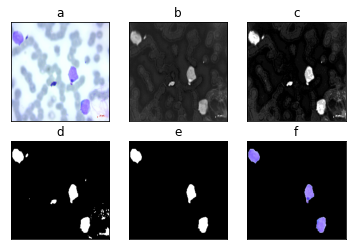

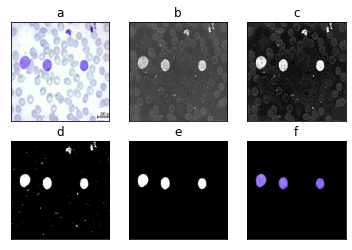

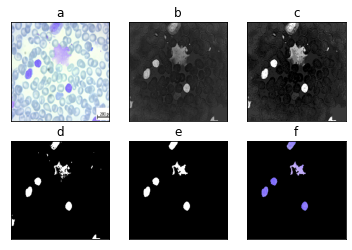

In [15]:
#----- print some samples of training dataset -------

n= 3

o_img=[]
a_img=[]
c_img=[]
b_img=[]
m_img=[]
out_img=[]

random.seed(865)
random.shuffle(data_list)

for img in data_list[:n]:
    i= cv2.imread(img)    
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i= cv2.resize(i,(224,224))
    o_img.append(i)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(i_lab)
    a_img.append(a)
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km= KMeans(n_clusters=7, random_state=0).fit(i2)
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    c_img.append(ic)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY)
    b_img.append(t)    
    fh = ndi.binary_fill_holes(t)   
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    #m2 = ndi.binary_fill_holes(m2)  
    #m1 = m1.astype(np.uint8)
    #m1_imgs.append(m1)
    m2 = m2.astype(np.uint8)  
    m_img.append(m2)
    out = cv2.bitwise_and(i, i, mask=m2)
    out_img.append(out)
    
for j in range(n):    
    for t in range(1):
        #print('=>',j+1,':')
        plt.subplot(2,3,1+t),plt.imshow(o_img[j])
        plt.title('a'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,2+t),plt.imshow(a_img[j],'gray')
        plt.title('b'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,3+t),plt.imshow(c_img[j],'gray')
        plt.title('c'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,4+t),plt.imshow(b_img[j],'gray')
        plt.title('d'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,5+t),plt.imshow(m_img[j],'gray')
        plt.title('e'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,6+t),plt.imshow(out_img[j])
        plt.title('f'),plt.xticks([]),plt.yticks([])
    plt.show()      

In [16]:
#a= sorted(list(paths.list_images('/tmp/prepared_data')))
#b = cv2.imread(a[1])
#plt.imshow(b)


# **Step 2:** Prepare data for training

2-1: Create dataframe from prepared data

In [17]:
#------- test Datafarame ---------

prepared_data_path = '/tmp/prepared_test/'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    prepared_data_list_labels.append(line.split(os.path.sep)[3])

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
test_df = pd.concat( [I_series, L_series], axis=1) 

print('-- test Datafarame --')
print(test_df.head())
#print number of each class:        
a=test_df['labels'].value_counts()
a

-- test Datafarame --
                                           filenames     labels
0  /tmp/prepared_test/EarlyPreB/[Malignant] early...  EarlyPreB
1     /tmp/prepared_test/PreB/[Malignant] Pre-B3.png       PreB
2             /tmp/prepared_test/benign/Benign87.png     benign
3   /tmp/prepared_test/PreB/[Malignant] Pre-B134.png       PreB
4  /tmp/prepared_test/EarlyPreB/[Malignant] early...  EarlyPreB


EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: labels, dtype: int64

In [18]:
#------- train/valid Datafarame -------

prepared_data_path = '/tmp/prepared_data/'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    prepared_data_list_labels.append(line.split(os.path.sep)[3])

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
df = pd.concat( [I_series, L_series], axis=1) 

print('-- train/valid Datafarame --')

print(df.head())
#print number of each class:        
a=df['labels'].value_counts()
a

-- train/valid Datafarame --
                                           filenames     labels
0  /tmp/prepared_data/EarlyPreB/[Malignant] early...  EarlyPreB
1           /tmp/prepared_data/benign/Benign3935.png     benign
2           /tmp/prepared_data/benign/Benign2971.png     benign
3  /tmp/prepared_data/ProB/[Malignant] Pro-B3727.png       ProB
4  /tmp/prepared_data/EarlyPreB/[Malignant] early...  EarlyPreB


EarlyPreB    1736
PreB         1724
ProB         1436
benign        938
Name: labels, dtype: int64

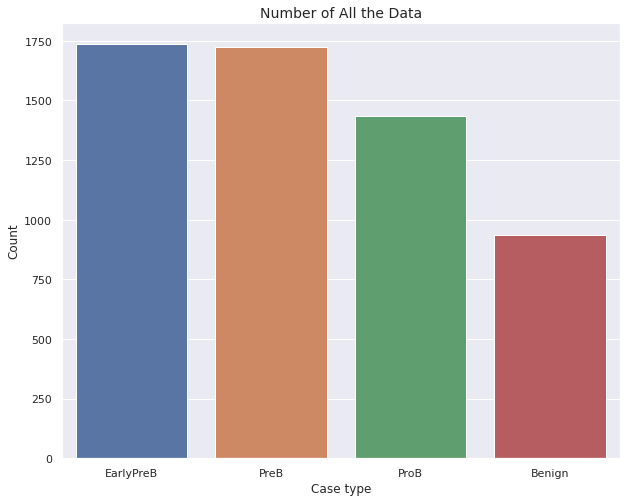

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.barplot(x= ['EarlyPreB','PreB','ProB','Benign'], y= [a[0],a[1],a[2],a[3]])
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
#plt.xticks(range(len(df.index)), ['a', 'b'])
plt.show()

2-2: Split the data frame for training and validation sets


In [20]:
SPLIT= 0.90

TRAIN_DF, VALID_DF = train_test_split(df, train_size=SPLIT, shuffle=True, random_state=88)

print('Train samples: ', len(TRAIN_DF))
print('Valid samples: ', len(VALID_DF))
print('Test samples : ', len(test_df))

Train samples:  5250
Valid samples:  584
Test samples :  325


In [21]:
test_df['labels'].value_counts()

EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: labels, dtype: int64

2-3: Augmentation, normalize and building data generators

In [22]:
BATCH_SIZE= 32
IMG_SHAPE= (224, 224, 3)
IMG_SIZE= (224, 224)

gen = ImageDataGenerator(rescale=1./255, 
                         vertical_flip=True,
                         horizontal_flip=True)
                         #rotation_range=10)

gen2 = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(TRAIN_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)

valid_gen= gen2.flow_from_dataframe(VALID_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)
test_gen= gen2.flow_from_dataframe(test_df,
                                   x_col= 'filenames',
                                   y_col= 'labels',
                                   target_size= IMG_SIZE,
                                   class_mode= 'categorical',
                                   color_mode= 'rgb',
                                   shuffle= True,
                                   batch_size= 325,
                                   seed=88
)


STEPS= int( len(train_gen.labels)/BATCH_SIZE)
print(STEPS)

Found 5250 validated image filenames belonging to 4 classes.
Found 584 validated image filenames belonging to 4 classes.
Found 325 validated image filenames belonging to 4 classes.
164


In [23]:
#images, labels = next(train_gen)
#plt.imshow(images[4])

#prepared_data_path = '/tmp/prepared_data/'
#a = (sorted(list(paths.list_images(prepared_data_path))))
#b=cv2.imread(a[6])
#plt.imshow(b)
#train_gen.labels

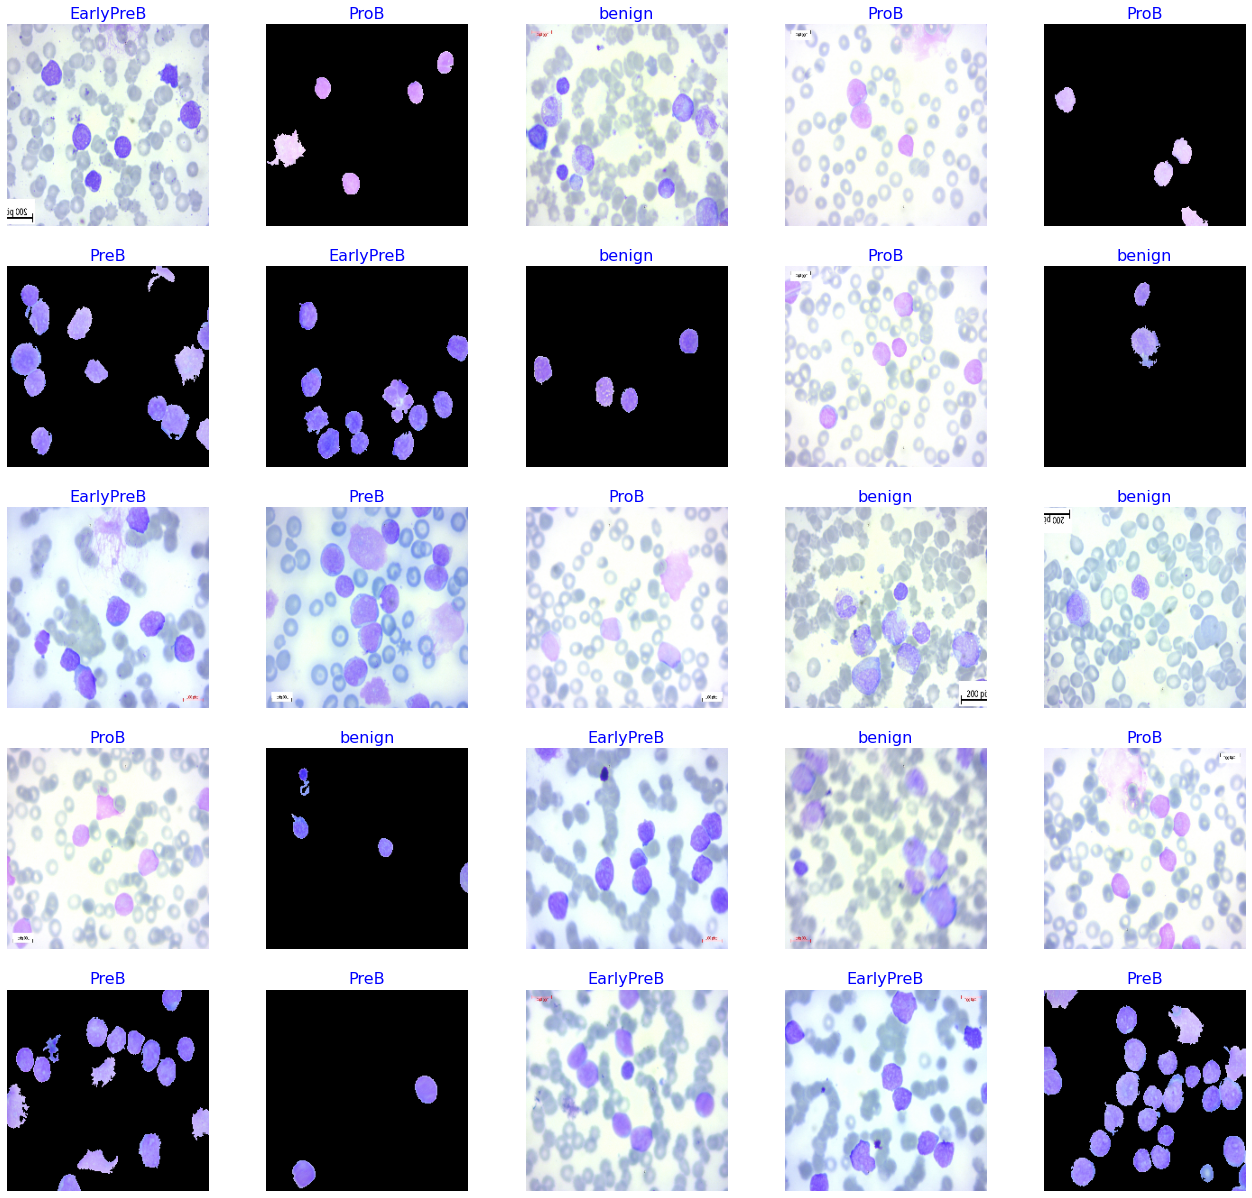

In [44]:
#---- print 25 samples of trainig dataset -----

genn=train_gen
class_dictionary= genn.class_indices
class_names = list(class_dictionary.keys())
images, labels = next(genn) #get sample batch from the generator
plt.figure(figsize=(20,20))
length = len(labels)

if length<25:
    r=length
else:
    r=25

for i in range(r):
    plt.subplot(5, 5, i+1)
    image= (images[i])
    #image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name= class_names[index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
plt.show()

# **Step 3:** Model creation and model training

3-1: Create the base model

In [45]:
#base_model = InceptionV3(include_top= False, weights="imagenet", input_shape=(224,224,3))
#base_model= tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3))
#tf.keras.applications.nasnet.NASNetLarge
base_model= tf.keras.applications.nasnet.NASNetMobile(include_top=False,weights='imagenet',input_shape=(224,224,3))
#tf.keras.applications.mobilenet_v2.MobileNetV2
#tf.keras.applications.MobileNetV3Small

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x) 
#x = Dense(128, activation= 'relu',kernel_initializer='he_uniform')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
predictions = Dense(4, activation= "softmax")(x) 
model = Model(inputs=base_model.input, outputs=predictions) 


20004864/19993432 [==============================] - 0s 0us/step


In [ ]:
#print(base_model.input)
#model.summary()

3-2: Model parameters

In [46]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08), #optimizer=Adam(learning_rate=0.00001,decay = 10e-5),
              metrics=['accuracy'])
             # option = run_opts)

3-2: Model training

In [47]:
history =         model.fit(x=train_gen,
                            epochs=30,
                            validation_data=valid_gen,
                            steps_per_epoch=None,
                            workers=2
                   )

Epoch 1/30
165/165 [==============================] - 90s 407ms/step - loss: 0.3289 - accuracy: 0.8829 - val_loss: 1.8901 - val_accuracy: 0.2928
Epoch 2/30
165/165 [==============================] - 63s 383ms/step - loss: 0.1171 - accuracy: 0.9592 - val_loss: 2.0151 - val_accuracy: 0.3562
Epoch 3/30
165/165 [==============================] - 63s 384ms/step - loss: 0.0842 - accuracy: 0.9703 - val_loss: 2.2808 - val_accuracy: 0.3990
Epoch 4/30
165/165 [==============================] - 63s 382ms/step - loss: 0.0611 - accuracy: 0.9789 - val_loss: 2.1009 - val_accuracy: 0.5034
Epoch 5/30
165/165 [==============================] - 64s 385ms/step - loss: 0.0461 - accuracy: 0.9851 - val_loss: 1.8793 - val_accuracy: 0.5428
Epoch 6/30
165/165 [==============================] - 63s 381ms/step - loss: 0.0408 - accuracy: 0.9870 - val_loss: 1.6296 - val_accuracy: 0.6113
Epoch 7/30
165/165 [==============================] - 63s 381ms/step - loss: 0.0374 - accuracy: 0.9888 - val_loss: 1.6011 - val_ac

# **Step 4:** Results

Includes accuracy and loss charts, Confusion matrix, and stuff 

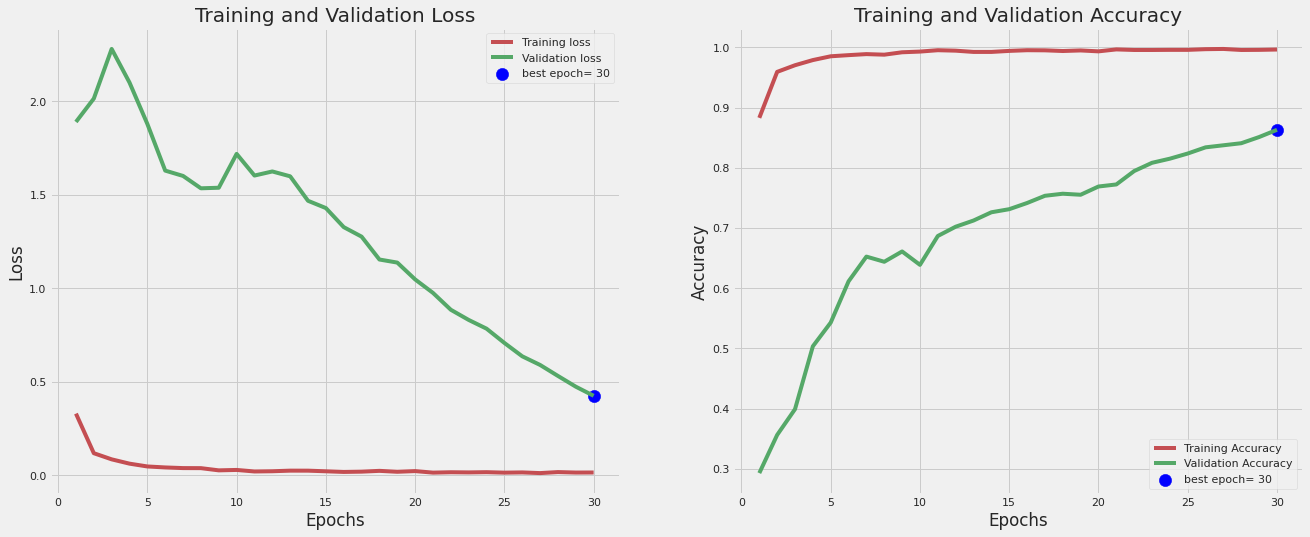

1/1 [==============================] - 2s 2s/step - loss: 0.2568 - accuracy: 0.9415
Model accuracy on test set: 94.15384531021118 (0, 255, 0) (55, 65, 80)


In [48]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()
    
    
tr_plot(history, 0)
acc=model.evaluate(test_gen,batch_size=32, steps=None, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print(msg, (0,255,0), (55,65,80))

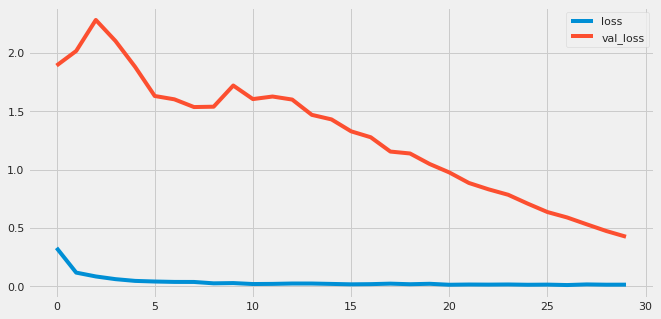

In [49]:
# Plotting train_loss vs val_loss
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()

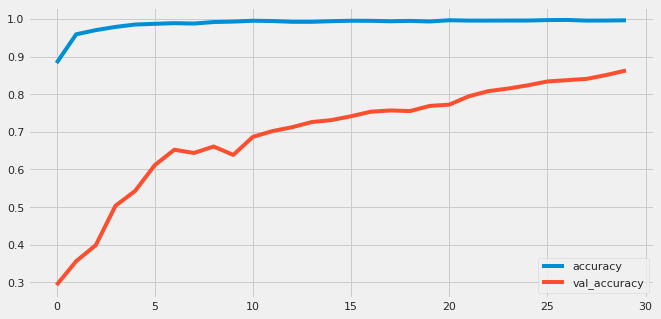

In [50]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='lower right')

In [51]:
from sklearn.metrics import confusion_matrix


for X_batch, y_batch in test_gen:
    y_test = y_batch
    X_test = X_batch
    break
    
print('test label shape',y_test.shape)
print('test image shape',X_test.shape)
print('Evaluate on test-data:')
model.evaluate(X_test,y_test)

pred = model.predict(X_test)

bin_predict = np.argmax(pred,axis=1)
y_test = np.argmax(y_test,axis=1)


#Confusion matrix:
matrix = confusion_matrix(y_test, bin_predict)
print('Confusion Matrix:\n',matrix)

test label shape (325, 4)
test image shape (325, 224, 224, 3)
Evaluate on test-data:
11/11 [==============================] - 4s 65ms/step - loss: 0.2568 - accuracy: 0.9415
Confusion Matrix:
 [[111   0   0   0]
 [  1  92   0   0]
 [  0   0  78   0]
 [ 18   0   0  25]]


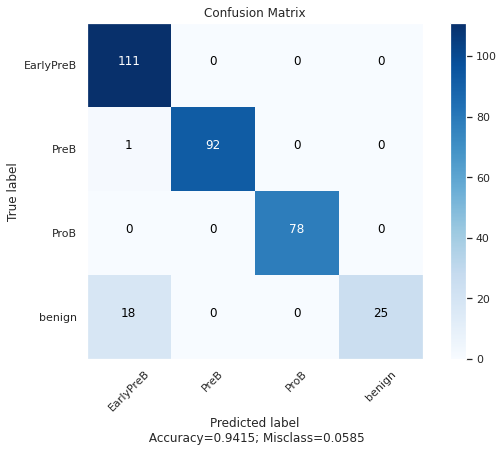

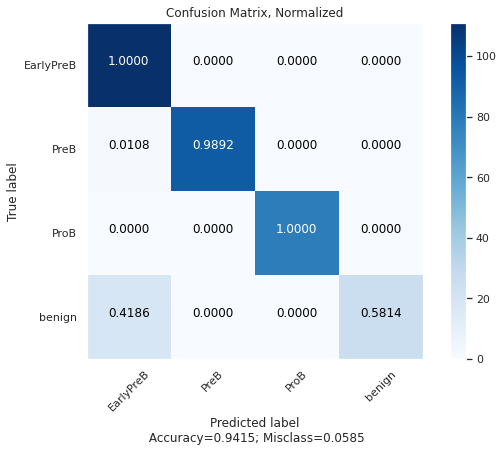

In [52]:
import itertools

#Plot the Confusion matrix:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

    
plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = False,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = True,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix, Normalized")



In [53]:
class_metrics = metrics.classification_report(y_test,bin_predict,labels=[0, 1])
print(class_metrics)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       111
           1       1.00      0.99      0.99        93

   micro avg       0.91      1.00      0.95       204
   macro avg       0.93      0.99      0.96       204
weighted avg       0.92      1.00      0.95       204



In [54]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MAE = mean_absolute_error(y_test, bin_predict)

print('MAE ----------------------------------------------:', MAE)
print('Accuracy -----------------------------------------:', ACC)
print('Precision (positive predictive value)-------------:', PPV)
print('Recall (Sensitivity, hit rate, true positive rate):', TPR)
print('Specificity (true negative rate)------------------:', TNR)
print('Negative Predictive Value-------------------------:', NPV)
print('Fall out (false positive rate)--------------------:', FPR)
print('False Negative Rate-------------------------------:', FNR)
print('False discovery rate------------------------------:', FDR)

Other Metrics:
MAE ----------------------------------------------: 0.16923076923076924
Accuracy -----------------------------------------: [0.94153846 0.99692308 1.         0.94461538]
Precision (positive predictive value)-------------: [0.85384615 1.         1.         1.        ]
Recall (Sensitivity, hit rate, true positive rate): [1.         0.98924731 1.         0.58139535]
Specificity (true negative rate)------------------: [0.91121495 1.         1.         1.        ]
Negative Predictive Value-------------------------: [1.         0.99570815 1.         0.94      ]
Fall out (false positive rate)--------------------: [0.08878505 0.         0.         0.        ]
False Negative Rate-------------------------------: [0.         0.01075269 0.         0.41860465]
False discovery rate------------------------------: [0.14615385 0.         0.         0.        ]


Shape of preds:  (325, 4)


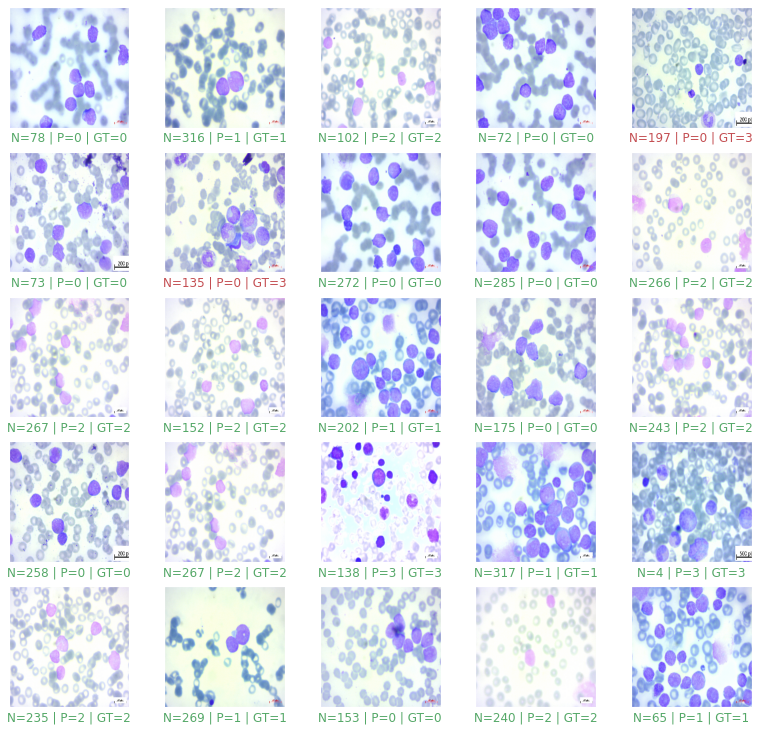

In [55]:
preds = model.predict(X_test)
#print(preds)
print('Shape of preds: ', preds.shape)
plt.figure(figsize = (12, 12))

number = np.random.choice(preds.shape[0])

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    number = np.random.choice(preds.shape[0])
    pred = np.argmax(preds[number])
    actual = (y_test[number])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('N={} | P={} | GT={}'.format(number, pred, actual), color = col) #N= number P= prediction GT= actual (ground truth)
    image= X_test[number]#cv2.cvtColor(X_test[number], cv2.COLOR_BGR2RGB)
    plt.imshow(((image* 255).astype(np.uint8)), cmap='binary')
plt.show()

# **Step 5:** Save the model


In [61]:
from tensorflow import lite


#!ls /
!ls /kaggle/working
!mkdir /kaggle/working/model3

converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('./model3/model3.tflite','wb').write(tfmodel)

#model.save("./Model1/model1")

NGC-DL-CONTAINER-LICENSE		mnt
bin					opt
boot					proc
dev					root
entrypoint.sh				run
etc					run_jupyter.sh
home					sbin
kaggle					src
lib					srv
lib32					sys
lib64					tmp
libnvinfer8_8.0.0-1+cuda11.0_amd64.deb	usr
libx32					var
media
__notebook_source__.ipynb  model2  model2.zip  model3
mkdir: cannot create directory ‘/kaggle/working/model3’: File exists


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-02-17 10:09:36.183870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 10:09:36.184407: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-02-17 10:09:36.184581: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-02-17 10:09:36.185215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 10:09:36.185677: I tensorflo

17171996

In [62]:
import os
os.chdir(r'./')
from IPython.display import FileLink
FileLink(r'./model3/model3.tflite')

/kaggle/working/model3/model3.tflite

In [ ]:
import shutil
shutil.make_archive('model3', 'zip', "./model3")

In [ ]:
import os
os.chdir(r'./')
from IPython.display import FileLink
FileLink(r'model3.zip')